### В этом ноутбуке представлены все этапы анализа: корреляции, мультиколлинеарность, feature selection, кластеризация, supervised learning, визуализация, пример предсказания.



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, NMF
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import adjusted_rand_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor


## 1. Unsupervised Learning (Кластеризация университетов)
### Загрузка и первичный анализ данных


In [4]:
df = pd.read_csv('universities_pivot.csv')
print(df.shape)
df.head()


(1197, 67)


,University,Short Name,Доля ППС возрастной категории моложе 40 лет,Доля ППС возрастной категории моложе 65 лет,"Доля ППС, имеющих ученые степени","Доля аспирантов (адъюнктов), интернов, ординаторов, ассистентов-стажеров, обучающихся в очной форме",Доля внебюджетных средств в доходах от научных исследований и разработок,Доля внебюджетных средств в доходах от образовательной деятельности,Доля доходов вуза из бюджета субъекта РФ и местного бюджета,Доля доходов вуза из внебюджетных источников,...,Площадь общежитий,Площадь учебно-лабораторных зданий,"Площадь, предназначенная для научно-исследовательских подразделений","Средний балл ЕГЭ студентов, принятых на обучение по программам бакалавриата и специалитета, по всем формам обучения",Средняя заработная плата ППС (без внешних совместителей и работающих по договорам ГПХ),Средняя заработная плата научных работников (без внешних совместителей и работающих по договорам ГПХ),Число диссертационных советов,"Число предприятий, с которыми заключены договоры на подготовку специалистов","Число предприятий, являющихся базами практики, с которыми оформлены договорные отношения","Число статей, подготовленных совместно с зарубежными организациями"
0,"""Институт пищевых технологий и дизайна"" - фили...",Институт пищевых технологий и дизайна - филиал...,8.11,81.08,83.78,0.0,0.0,13.55,NaN,NaN,...,1795,12266,54,56.90,86.74,0.00,0,0,0,0
1,АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОБРАЗОВАТЕЛЬНАЯ ОРГА...,АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОБРАЗОВАТЕЛЬНАЯ ОРГА...,50.00,100.00,100.00,0.0,0.0,100.00,0.0,100.00,...,0,1335,0,67.80,10.98,0.00,0,0,0,0
2,Автономная некоммерческая образовательная орга...,Автономная некоммерческая образовательная орга...,15.38,84.62,84.62,0.0,100.0,100.00,0.0,100.00,...,0,1322,36,64.30,78.40,20.00,0,0,34,4
3,Автономная некоммерческая образовательная орга...,Автономная некоммерческая образовательная орга...,26.32,91.23,71.93,0.0,100.0,100.00,0.0,100.00,...,0,15022,60,57.31,98.99,98.69,0,0,41,6
4,Автономная некоммерческая образовательная орга...,Автономная некоммерческая образовательная орга...,14.89,82.98,93.62,100.0,100.0,99.83,0.0,99.86,...,0,3312,941,0.00,212.98,95.51,0,0,0,16


### Корреляция, мультиколлинеарность, отбор признаков


In [8]:
names = df[['University', 'Short Name']]
X = df.drop(['University', 'Short Name'], axis=1)
X = X.apply(pd.to_numeric, errors='coerce')
X = X.fillna(X.median())
X = X.loc[:, X.std() > 0]
X = X.dropna(axis=1)

# Пары с корр > 0.8
corr = pd.DataFrame(X).corr()
high_corr = np.where(np.abs(corr) > 0.8)
high_corr_pairs = [(corr.index[x], corr.columns[y]) for x, y in zip(*high_corr) if x != y and x < y]
print('Highly correlated pairs:', high_corr_pairs)

# VIF
X_vif = X.copy()
X_vif['const'] = 1
vif_df = pd.DataFrame()
vif_df['feature'] = X_vif.columns
vif_df['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print(vif_df[vif_df['VIF'] > 5])


Highly correlated pairs: [('Доля доходов вуза  из внебюджетных источников', 'Доля доходов вуза  из федерального бюджета'), ('Доля доходов филиала  из внебюджетных источников', 'Доля доходов филиала  из федерального бюджета'), ('Доходы вуза  из внебюджетных источников', 'Доходы вуза  из всех источников'), ('Доходы вуза  из всех источников', 'Количество персональных компьютеров'), ('Доходы вуза  из всех источников', 'Общая численность ППС (без внешних совместителей и работающих по договорам ГПХ)'), ('Доходы вуза  из всех источников', 'Общая численность работников образовательной организации (без внешних совместителей и работающих по договорам ГПХ)'), ('Доходы вуза  из всех источников', 'Общий объем средств, поступивших (за отчетный год) от выполнения НИОКР, выполненных собственными силами'), ('Доходы вуза  из всех источников', 'Общий объем средств, поступивших (за отчетный год) от выполнения работ, услуг, связанных с научными, научно-техническими, творческими услугами и разработками, вып

### Стандартизация и снижение размерности (PCA)


Удалено по корреляции >0.8: ['Доля доходов вуза  из федерального бюджета', 'Доля доходов филиала  из федерального бюджета', 'Доходы вуза  из всех источников', 'Доходы филиала  из всех источников', 'Количество персональных компьютеров', 'Общая площадь зданий (помещений)', 'Общая численность ППС (без внешних совместителей и работающих по договорам ГПХ)', 'Общая численность работников образовательной организации (без внешних совместителей и работающих по договорам ГПХ)', 'Общая численность студентов, обучающихся по программам бакалавриата, специалитета, магистратуры', 'Общий объем средств, поступивших (за отчетный год) от выполнения НИОКР, выполненных собственными силами', 'Общий объем средств, поступивших (за отчетный год) от выполнения работ, услуг, связанных с научными, научно-техническими, творческими услугами и разработками, выполненных собственными силами', 'Площадь общежитий', 'Площадь учебно-лабораторных зданий']
Удаляем по VIF: Доля доходов филиала  от образовательной деятельност

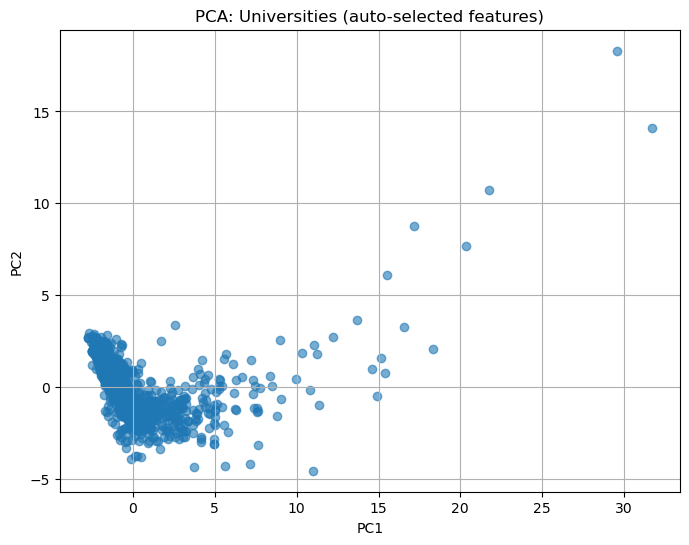

PCA Components:
PC1:
   Доля ППС возрастной категории моложе 40 лет: 0.09
   Доля аспирантов (адъюнктов), интернов, ординаторов, ассистентов-стажеров, обучающихся в очной форме: 0.19
   Доля внебюджетных средств в доходах от научных исследований и разработок: -0.03
   Доля внебюджетных средств в доходах от образовательной деятельности: -0.10
   Доля доходов вуза  из бюджета субъекта РФ и местного бюджета: 0.00
   Доля доходов вуза  из внебюджетных источников: -0.04
   Доля доходов вуза  от научных исследований и разработок в общих доходах вуза: 0.13
   Доля доходов филиала  из бюджета субъекта РФ и местного бюджета: -0.02
   Доля доходов филиала  от научных исследований и разработок в общих доходах филиала: -0.02
   Доля иностранных студентов в общей численности студентов, обучающихся по программам бакалавриата, специалитета, магистратуры: 0.14
   Доля научных работников, имеющих ученые степени: 0.06
   Доля обучающихся по программам бакалавриата в общей численности обучающихся по прог

In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt

# Шаг 1 Удаляем признаки с корреляцией > 0.8
def remove_highly_correlated(df, threshold=0.8):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return df.drop(columns=to_drop), to_drop

X_corr, dropped_corr = remove_highly_correlated(X, threshold=0.8)
print(f'Удалено по корреляции >0.8: {dropped_corr}')

# Шаг 2 Удаляем признаки с высоким vif
def calculate_vif(df):
    vif = pd.Series(
        [variance_inflation_factor(df.values, i) for i in range(df.shape[1])],
        index=df.columns
    )
    return vif

X_vif = X_corr.copy()
while True:
    vif = calculate_vif(X_vif)
    max_vif = vif.max()
    if max_vif > 10:
        drop_feat = vif.idxmax()
        print(f'Удаляем по VIF: {drop_feat} (VIF={max_vif:.1f})')
        X_vif = X_vif.drop(columns=[drop_feat])
    else:
        break

print(f'Финальные признаки для анализа: {list(X_vif.columns)}')

# Шаг 3 Стандартизация
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_vif)

# Шаг 4 PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.6)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA: Universities (auto-selected features)')
plt.grid(True)
plt.show()

# Вклад признаков
print("PCA Components:")
for i, comp in enumerate(pca.components_):
    print(f"PC{i+1}:")
    for feat, weight in zip(X_vif.columns, comp):
        print(f"   {feat}: {weight:.2f}")


### Кластеризация (KMeans, Agglomerative, DBSCAN) и сравнение


C:\Users\Vyacheslav\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


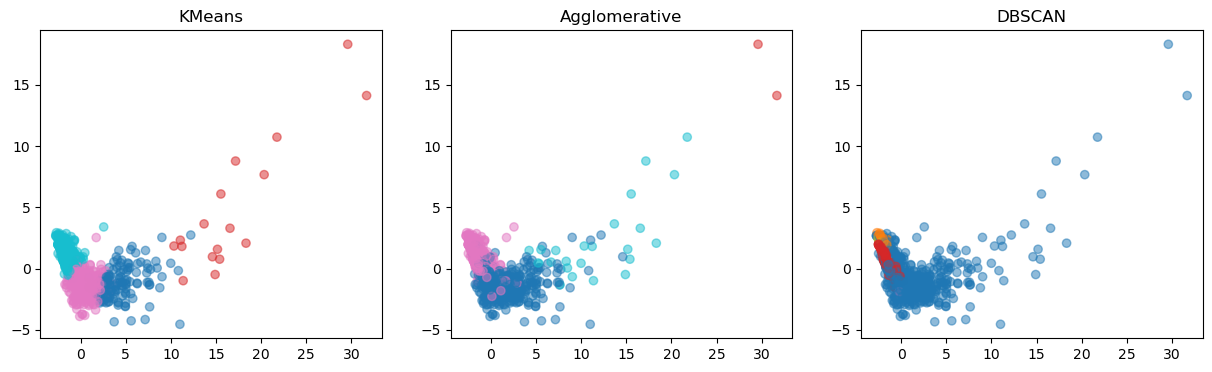

Adjusted Rand Index (KMeans vs Agglomerative): 0.535


In [16]:
kmeans = KMeans(n_clusters=4, random_state=0)
labels_kmeans = kmeans.fit_predict(X_scaled)
agglo = AgglomerativeClustering(n_clusters=4)
labels_agglo = agglo.fit_predict(X_scaled)
dbscan = DBSCAN(eps=2, min_samples=5)
labels_dbscan = dbscan.fit_predict(X_scaled)

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_kmeans, cmap='tab10', alpha=0.5)
plt.title('KMeans')
plt.subplot(1,3,2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_agglo, cmap='tab10', alpha=0.5)
plt.title('Agglomerative')
plt.subplot(1,3,3)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_dbscan, cmap='tab10', alpha=0.5)
plt.title('DBSCAN')
plt.show()
ari = adjusted_rand_score(labels_kmeans, labels_agglo)
print(f'Adjusted Rand Index (KMeans vs Agglomerative): {ari:.3f}')


> Вывод: Удаление мультиколлинеарных признаков и констант повышает устойчивость кластеризации. ARI иллюстрирует, что разные методы могут видеть группы по-разному, если структура данных не идеально «кластерная».


## 2. Supervised Learning (Crop Recommendation Dataset)
### Анализ и корреляция признаков


In [20]:
crop = pd.read_csv('Crop_recommendation.csv')
print(crop.shape)
crop.head()


(2200, 8)


,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


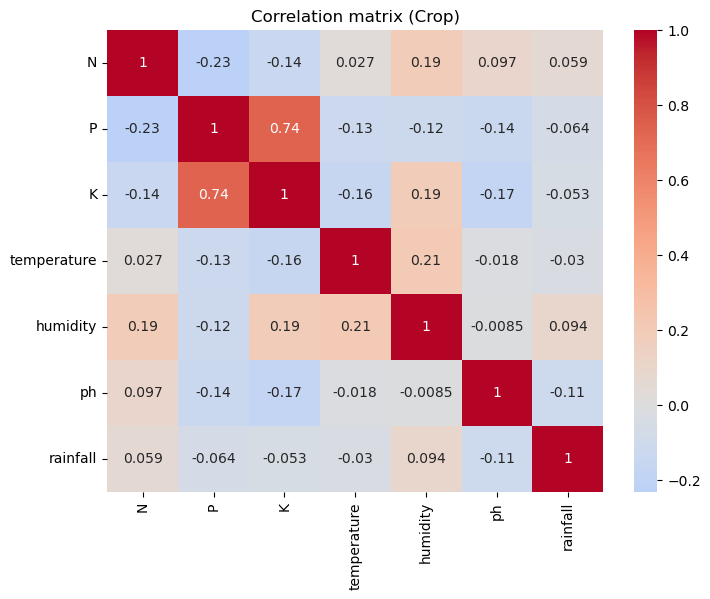

  feature         VIF
7   const  127.038641


In [22]:
corr_crop = crop.drop('label', axis=1).corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_crop, cmap='coolwarm', center=0, annot=True)
plt.title('Correlation matrix (Crop)')
plt.show()

# VIF
X_crop = crop.drop('label', axis=1)
X_crop['const'] = 1
vif_crop = pd.DataFrame()
vif_crop['feature'] = X_crop.columns
vif_crop['VIF'] = [variance_inflation_factor(X_crop.values, i) for i in range(X_crop.shape[1])]
print(vif_crop[vif_crop['VIF'] > 5])
X_crop = X_crop.drop('const', axis=1)


### Train/Test Split, масштабирование для SVC/LR


In [25]:
X = crop.drop('label', axis=1)
y = crop['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler_svc = StandardScaler()
X_train_scaled = scaler_svc.fit_transform(X_train)
X_test_scaled = scaler_svc.transform(X_test)


### Обучение моделей, важность признаков, сравнение точности


Logistic Regression: Accuracy = 0.964
Decision Tree: Accuracy = 0.986
Random Forest: Accuracy = 0.993
Naive Bayes: Accuracy = 0.995
KNN: Accuracy = 0.970
SVC: Accuracy = 0.977
MLP: Accuracy = 0.955


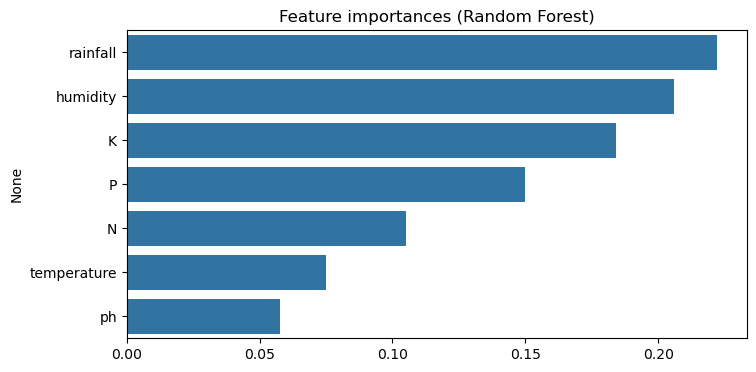

In [28]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=2000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Naive Bayes': GaussianNB(),
    'KNN': KNeighborsClassifier(),
    'SVC': SVC(kernel='linear', C=1),
    'MLP': MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)
}
results = {}
for name, model in models.items():
    if name in ['Logistic Regression', 'SVC']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    acc = (y_pred == y_test).mean()
    results[name] = acc
    print(f"{name}: Accuracy = {acc:.3f}")
rf = models['Random Forest']
feature_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8,4))
sns.barplot(x=feature_imp.values, y=feature_imp.index)
plt.title('Feature importances (Random Forest)')
plt.show()


### Confusion Matrix, Classification Report


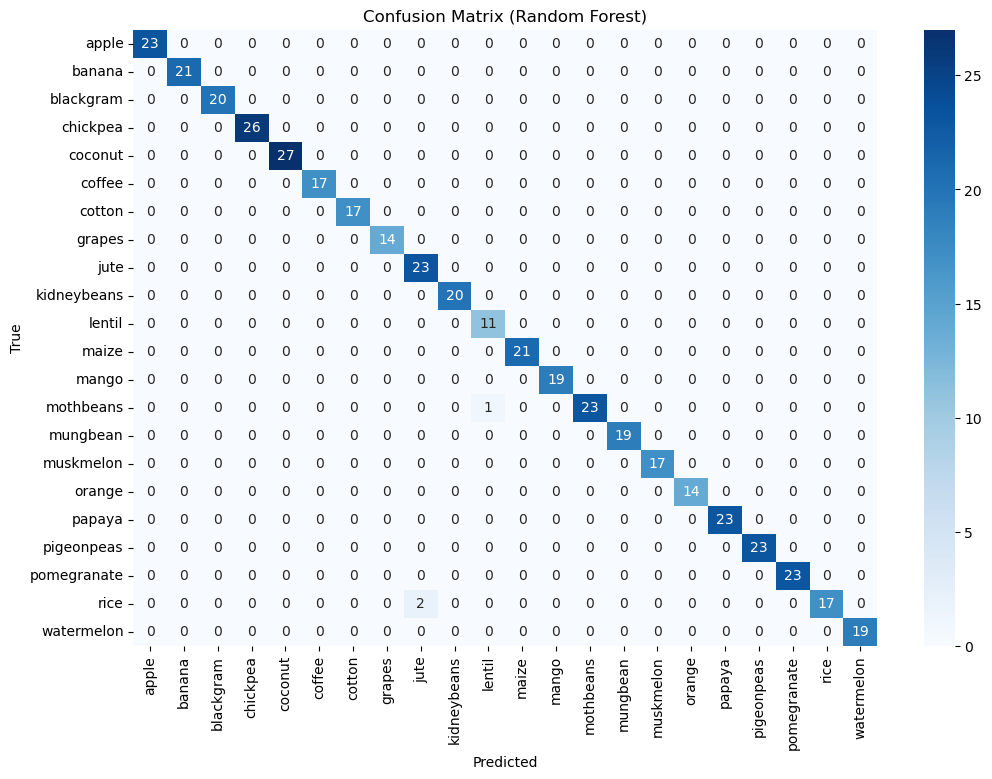

Classification Report (Random Forest):
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        23
      banana       1.00      1.00      1.00        21
   blackgram       1.00      1.00      1.00        20
    chickpea       1.00      1.00      1.00        26
     coconut       1.00      1.00      1.00        27
      coffee       1.00      1.00      1.00        17
      cotton       1.00      1.00      1.00        17
      grapes       1.00      1.00      1.00        14
        jute       0.92      1.00      0.96        23
 kidneybeans       1.00      1.00      1.00        20
      lentil       0.92      1.00      0.96        11
       maize       1.00      1.00      1.00        21
       mango       1.00      1.00      1.00        19
   mothbeans       1.00      0.96      0.98        24
    mungbean       1.00      1.00      1.00        19
   muskmelon       1.00      1.00      1.00        17
      orange       1.00      1.00      1.0

In [31]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
plt.figure(figsize=(12,8))
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix (Random Forest)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
print("Classification Report (Random Forest):")
print(classification_report(y_test, y_pred))


### Пример предсказания для новых данных


In [34]:
my_sample = pd.DataFrame({
    'N': [90],
    'P': [42],
    'K': [43],
    'temperature': [23.5],
    'humidity': [84],
    'ph': [6.3],
    'rainfall': [110]
})
predicted_crop = model.predict(my_sample)[0]
print(f"Рекомендуемая культура для указанных параметров: {predicted_crop}")


Рекомендуемая культура для указанных параметров: jute


> **Выводы:**
> - Мультиколлинеарность влияет на стабильность моделей и отбор признаков.
> - PCA/NMF позволяют визуализировать данные и упростить анализ.
> - Кластеризация позволяет находить скрытые группы, а ARI сравнивает их.
> - Random Forest и MLPClassifier показывают отличную точность для классификации культур, confusion matrix подтверждает высокое качество.
> - Модель пригодна для реальных рекомендаций по новым агро-данным.


4. Нейронные сети (10%)

In [38]:

from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)
mlp.fit(X_train, y_train)
mlp_score = mlp.score(X_test, y_test)
print(f"MLPClassifier: Accuracy = {mlp_score:.3f}")

MLPClassifier: Accuracy = 0.932
